In [4]:
import pandas as pd
import numpy as np
from source.model import solve_hjb_y, solve_hjb_y_jump
from source.utilities import find_nearest_value

In [8]:
# Uncertainty parameters
ξ_w = 10_000
ξ_a = 1/100
ξ_p = 5

# Preference
η = .032
δ = .01

# Climate sensitivity
θ = pd.read_csv('data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)

# Damage function
σ_y = 1.2*np.mean(θ)
y_bar = 2.
γ_1 = 1.7675/10000
γ_2 = .0022*2
γ_2p = np.array([0, .0197*2, .3853*2])
πd_o = np.array([1./3, 1./3, 1./3])

y_step = .02
y_grid_long = np.arange(0., 4., y_step)
y_grid_short = np.arange(0., 2+y_step, y_step)
n_bar = find_nearest_value(y_grid_long, y_bar) + 1

# Prepare ϕ conditional on low, high, extreme damage
model_res_list = []
for γ_2p_i in γ_2p:
    model_args = (η, δ, σ_y, y_bar, γ_1, γ_2, γ_2p_i, θ, πc_o, ξ_w, ξ_a) 
    model_res = solve_hjb_y(y_grid_long, model_args, v0=None, ϵ=1.,
                            tol=1e-8, max_iter=5_000, print_iteration=False)
    model_res_list.append(model_res)

ϕ_list = [res['v'] for res in model_res_list]

# Change grid from 0-4 to 0-2
ϕ_i = np.array([temp[:n_bar] for temp in ϕ_list])

# Compute ϕ with jump (impose boundary condition)
model_args = (η, δ, σ_y, y_bar, γ_1, γ_2, γ_2p, θ, πc_o, ϕ_i, πd_o, ξ_w, ξ_p, ξ_a)
model_res = solve_hjb_y_jump(y_grid_short, model_args, 
                             v0=np.average(ϕ_i, weights=πd_o, axis=0),
                             ϵ=1., tol=1e-8, max_iter=5_000, print_iteration=False)

Converged. Total iteration 5000: LHS Error: 2.693299440625907e-05; RHS Error 8.023424065169149e-05
Converged. Total iteration 1507: LHS Error: 9.965680058954263e-09; RHS Error 0.0004700251655244958
Converged. Total iteration 1621: LHS Error: 9.95231452805001e-09; RHS Error 0.0022787956387432485
Converged. Total iteration 443: LHS Error: 9.76240155381447e-09; RHS Error 0.0008703086250559725


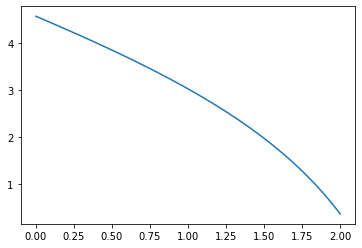

In [9]:
import matplotlib.pyplot as plt
plt.plot(y_grid_short, model_res['v'])